# Fine-Tune Mistral-7B-Instruct

We want to train the Mistral LLM to extract action items from call transcriptions.

## Imports and Preparations

In [ ]:
# Setup cell - run this after each runtime restart
!pip install -q bitsandbytes>=0.41.1
!pip install -q transformers>=4.34.0
!pip install -q peft>=0.5.0
!pip install -q accelerate>=0.24.0

In [ ]:
# !pip uninstall -y bitsandbytes

In [ ]:
# !pip freeze | grep bitsandbytes

In [ ]:
# !apt-get -y install -qq cmake

In [ ]:
# !pip install -q https://github.com/Keith-Hon/bitsandbytes-cudaXX/raw/main/bitsandbytes-0.41.1-py3-none-any.whl


In [ ]:
# !pip install -U auto-gptq  # For the quantized model

In [ ]:
# !pip install -U optimum

In [ ]:
# !pip install -U bitsandbytes==0.41.1

In [ ]:
# !pip freeze | grep bitsandbytes

In [ ]:
# !pip install -U peft>=0.5.0

In [ ]:
# !pip install -U transformers>=4.34.0

In [ ]:
# !pip install -U accelerate>=0.21.0

In [ ]:
# !pip install flash_attn

In [ ]:
# Imports
import json
import torch
from torch.utils.data import Dataset, DataLoader
import re
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import (
    LoraConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
    TaskType,
    PeftModel,
    PeftConfig
)
from huggingface_hub import login

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import os
from tqdm import tqdm

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np

In [ ]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
# Read from Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

## Define Input max Length

In [ ]:
data = json.load(open('/content/drive/My Drive/Colab_Notebooks/transcriptions_for_training_with_validation_formatted.json', 'r'))

In [ ]:
data[0].keys()

dict_keys(['uuid', 'transcript', 'response', 'validation'])

In [ ]:
instruction = (
    "Extract action items from the following conversation. "
    "Format each action item as:\n"
    "- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>\n"
    "Conversation:\n{}"
)

In [ ]:
all_prompts = [f"<s>[INST] {instruction.format(item['transcript'])} [/INST]\n{item['response']}</s>" for item in data]

In [ ]:
all_prompts[0]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
# Tokenize
encoded = tokenizer(all_prompts,
                    max_length=1024,
                    truncation=True,
                   padding='max_length',
                   return_tensors='pt'
            )

In [ ]:
n_tokens = [encoded["attention_mask"][idx].sum().item() for idx in range(len(encoded["attention_mask"]))]

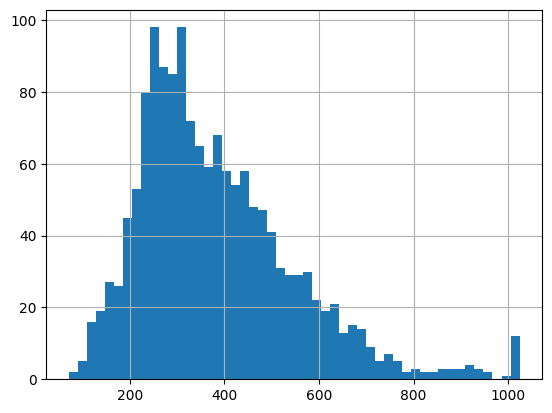

In [ ]:
plt.hist(n_tokens, bins=50)
plt.grid()

**I choose to set the max length at 1024, although it has memory cost. I don't want to lose the information (only for ~15 samples).**

## Run Functions

In [ ]:
class ActionItemsDataset(Dataset):
    """
    Custom PyTorch Dataset for handling conversation data and action items extraction.
    This dataset processes conversations and their corresponding action items,
    preparing them for training a language model to extract action items.
    """
    def __init__(self, json_file_path, tokenizer, max_length=1024):
        """
        Initialize the dataset.

        Args:
            json_file_path (str): Path to JSON file containing conversations and responses
            tokenizer: HuggingFace tokenizer for processing text
            max_length (int): Maximum sequence length for tokenization
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        # Process all data at initialization time
        self.examples = self.load_and_process_data(json_file_path)

    def format_action_items(self, response):
        """
        Format action items to ensure they follow the required structure.
        This function handles three cases:
        1. "No follow-up action items agreed upon." -> returns as is
        2. Already formatted items starting with "- Action:" -> returns as is
        3. Other formats -> converts to required format

        Args:
            response (str): The original response from the dataset
                Could be either:
                - "No follow-up action items agreed upon."
                - A properly formatted action item starting with "- Action:"
                - A response needing formatting

        Returns:
            str: Formatted response in the required structure or original "No follow-up" message

        Examples:
            Input: "No follow-up action items agreed upon."
            Output: "No follow-up action items agreed upon."

            Input: "- Action: Call client. When: tomorrow. By Who: Agent"
            Output: Same as input (already formatted)

            Input: "Call client tomorrow\nSend email"
            Output: "- Action: Call client tomorrow. When: N/A. By Who: N/A\n- Action: Send email. When: N/A. By Who: N/A"
        """
        # Case 1: No action items response - return as is
        if response == "No follow-up action items agreed upon.":
            return response

        # Case 2: Already properly formatted - return as is
        if response.startswith("- Action:"):
            return response

        # Case 3: Needs formatting
        formatted_items = []
        # Split response into lines and process each line
        for line in response.split('\n'):
            if line.strip():  # Skip empty lines
                # Try to find existing format components
                action_match = re.search(r'Action: (.+?)(?=\. When:|$)', line)
                when_match = re.search(r'When: (.+?)(?=\. By Who:|$)', line)
                who_match = re.search(r'By Who: (.+?)$', line)

                # Extract components or use defaults
                action = action_match.group(1) if action_match else line.strip()
                when = when_match.group(1) if when_match else "N/A"
                who = who_match.group(1) if who_match else "N/A"

                # Create formatted action item
                formatted_items.append(f"- Action: {action}. When: {when}. By Who: {who}")

        # Join all formatted items with newlines
        return '\n'.join(formatted_items) if formatted_items else response

    def load_and_process_data(self, json_file_path):
        """
        Load JSON data and process each conversation-response pair.

        Args:
            json_file_path (str): Path to the JSON file containing the dataset

        Returns:
            list: List of processed and tokenized examples ready for training

        The function:
        1. Loads the JSON file
        2. Processes each conversation-response pair
        3. Creates instruction prompts
        4. Tokenizes the data
        """
        # Load JSON file
        with open(json_file_path, 'r', encoding='utf-8') as f:
            data = json.load(f)

        processed_data = []
        for item in data:
            # Get raw transcript and format the response
            transcript = item['transcript'].strip()
            formatted_response = self.format_action_items(item['response'])

            # Create instruction prompt
            instruction = (
                "Extract action items from the following conversation. "
                "Important instructions:\n"
                "1. If any speakers introduce themselves or their names are mentioned, "
                "use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.\n"
                "2. Format each action item as:\n"
                "- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>\n"
                "3. If there are no action items, respond with: \"No follow-up action items agreed upon.\"\n\n"
                f"Conversation:\n{transcript}"
            )

            # Create full prompt with Mistral instruction format
            full_prompt = f"<s>[INST] {instruction} [/INST]\n{formatted_response}</s>"

            # Tokenize the full prompt
            encoded = self.tokenizer(
                full_prompt,
                max_length=self.max_length,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )

            # Store tokenized data
            processed_data.append({
                'input_ids': encoded['input_ids'][0],
                'attention_mask': encoded['attention_mask'][0]
            })

        return processed_data

    def __len__(self):
        """Return the number of examples in the dataset."""
        return len(self.examples)

    def __getitem__(self, idx):
        """
        Get a single example from the dataset.

        Args:
            idx (int): Index of the example to retrieve

        Returns:
            dict: Contains:
                - input_ids: Tokenized input sequence
                - attention_mask: Attention mask for the sequence
                - labels: Same as input_ids for causal language modeling
        """
        return {
            'input_ids': self.examples[idx]['input_ids'],
            'attention_mask': self.examples[idx]['attention_mask'],
            'labels': self.examples[idx]['input_ids'].clone()  # For causal language modeling
        }

In [ ]:
def prepare_model_and_tokenizer():
    """
    Initialize and configure the model and tokenizer with optimizations.
    Includes quantization and LoRA configuration.

    Returns:
        tuple: (model, tokenizer)
    """
    model_name = "mistralai/Mistral-7B-Instruct-v0.1"

    # # Configure 8-bit quantization
    # quantization_config = BitsAndBytesConfig(
    #     load_in_8bit=True,
    #     bnb_8bit_compute_dtype=torch.float16,
    #     bnb_8bit_use_double_quant=True,
    #     bnb_8bit_quant_type="nf8"
    # )

    # # More aggressive quantization
    # quantization_config = BitsAndBytesConfig(
    #     load_in_8bit=True,
    #     bnb_8bit_compute_dtype=torch.float16,
    #     bnb_8bit_use_double_quant=True,
    #     bnb_8bit_quant_type="nf8",
    #     llm_int8_threshold=6.0,
    #     llm_int8_has_fp16_weight=True
    # )


    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,  # Changed to 4-bit
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )


    # Initialize tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        trust_remote_code=True
    )
    tokenizer.pad_token = tokenizer.eos_token

    # # Load model with optimizations
    # model = AutoModelForCausalLM.from_pretrained(
    #     model_name,
    #     quantization_config=quantization_config,
    #     torch_dtype=torch.float16,
    #     device_map="auto",
    #     trust_remote_code=True,
    #     # attn_implementation="flash_attention_2"  # removed since it requires specific CUDA versions and installations
    # )

    # Load model with more memory optimizations
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=quantization_config,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
        # max_memory={0: "13GB"},  # Limit GPU memory usage
        # offload_folder="offload",  # Enable CPU offloading if needed
    )

    # Prepare model for LoRA fine-tuning
    model = prepare_model_for_kbit_training(model)

    # Configure LoRA
    lora_config = LoraConfig(
        r=8,                    # Rank of the update matrices
        lora_alpha=32,          # Alpha parameter for LoRA scaling
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Which modules to apply LoRA to
        lora_dropout=0.05,
        bias="none",
        task_type=TaskType.CAUSAL_LM # "CAUSAL_LM"
    )


    # Apply LoRA to the model
    model = get_peft_model(model, lora_config)
    model.print_trainable_parameters()

    return model, tokenizer

In [ ]:
def create_data_splits(dataset, train_size=0.75, val_size=0.13, test_size=0.12):
    """
    Split dataset into train, validation, and test sets.
    """
    assert abs(train_size + val_size + test_size - 1.0) < 1e-6, "Split sizes must sum to 1"

    total_size = len(dataset)
    train_len = int(total_size * train_size)
    val_len = int(total_size * val_size)
    test_len = total_size - train_len - val_len

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset,
        [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, val_dataset, test_dataset


def evaluate_model(model, tokenizer, val_loader, device):  # Add tokenizer parameter
    """
    Evaluate the model on validation set.
    """
    model.eval()
    total_loss = 0
    generated_samples = []

    with torch.no_grad():
        # Quantitative evaluation (loss)
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()

        # Qualitative evaluation (generate samples)
        for i, batch in enumerate(val_loader):
            if i >= 5:  # Only generate a few samples
                break

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Find where [/INST] token ends
            inst_tokens = tokenizer.encode('[/INST]', add_special_tokens=False)  # Use passed tokenizer
            inst_end = None
            for i in range(len(input_ids[0]) - len(inst_tokens)):
                if input_ids[0][i:i+len(inst_tokens)].tolist() == inst_tokens:
                    inst_end = i + len(inst_tokens)
                    break

            if inst_end:
                generated = model.generate(
                    input_ids=input_ids[:, :inst_end],
                    attention_mask=attention_mask[:, :inst_end],
                    max_new_tokens=200,
                    temperature=0.0,
                    num_beams=1,
                    pad_token_id=tokenizer.eos_token_id  # Use passed tokenizer
                )

                generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)  # Use passed tokenizer
                actual_text = tokenizer.decode(input_ids[0][inst_end:], skip_special_tokens=True)  # Use passed tokenizer
                generated_samples.append({
                    'generated': generated_text,
                    'actual': actual_text
                })

    avg_loss = total_loss / len(val_loader)
    return avg_loss, generated_samples

def train_model(model, tokenizer, train_loader, val_loader, num_epochs, learning_rate, device,
                gradient_accumulation_steps=8, max_grad_norm=1.0,
                checkpoint_path="./checkpoints", eval_steps=100):
    """
    Train the model with periodic validation.
    """
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_loss = float('inf')
    global_step = 0  # Add global step counter

    # Training loop
    model.train()
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")

        progress_bar = tqdm(total=len(train_loader), desc=f"Training")
        running_loss = 0.0

        for step, batch in enumerate(train_loader):
            # Training step
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / gradient_accumulation_steps
            loss.backward()

            running_loss += loss.item() * gradient_accumulation_steps

            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            global_step += 1  # Increment for each batch

            # Periodic validation based on global step
            if global_step % eval_steps == 0:
                val_loss, generated_samples = evaluate_model(model, tokenizer, val_loader, device)

                print(f"\nStep {global_step} Validation:")
                print(f"Validation Loss: {val_loss:.4f}")
                print("\nGenerated Samples Example:")
                for i, sample in enumerate(generated_samples[:1]):  # Show first sample
                    print(f"Generated: {sample['generated']}")
                    print(f"Actual: {sample['actual']}")
                    print("-" * 50)

                # Save best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    model.save_pretrained(os.path.join(checkpoint_path, "best_model"))

                model.train()  # Back to training mode

            progress_bar.update(1)
            progress_bar.set_postfix({
                'loss': running_loss / (step + 1),
                'step': global_step
            })
        # Save epoch checkpint
        model.save_pretrained(f"/content/drive/My Drive/Colab_Notebooks/final-action-items-model-base-{epoch}")


def evaluate_test_set(model, tokenizer, test_loader, device):
    """
    Evaluate model on test set and return log loss.
    """
    model.eval()
    total_loss = 0
    num_samples = 0

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item() * len(input_ids)
            num_samples += len(input_ids)

    avg_loss = total_loss / num_samples
    return avg_loss

## Training

In [ ]:
!nvidia-smi

Fri Jan 10 20:35:45 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0              43W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')

In [ ]:
# Initialize model and tokenizer
model, tokenizer = prepare_model_and_tokenizer()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

trainable params: 6,815,744 || all params: 7,248,547,840 || trainable%: 0.0940


In [ ]:
# # After model creation:
# model.gradient_checkpointing_enable()

In [ ]:
# Create dataset
dataset = ActionItemsDataset('/content/drive/My Drive/Colab_Notebooks/transcriptions_for_training_with_validation_formatted.json', tokenizer)

In [ ]:
dataset[0]

{'input_ids': tensor([    2,     2,     2,  ...,  3714, 28723,     2]),
 'attention_mask': tensor([0, 0, 0,  ..., 1, 1, 1]),
 'labels': tensor([    2,     2,     2,  ...,  3714, 28723,     2])}

In [ ]:
len(dataset)

1500

In [ ]:
# Split data
train_dataset, val_dataset, test_dataset = create_data_splits(dataset)

In [ ]:
len(train_dataset)

1125

In [ ]:
# Create dataloaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2
)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Evaluate on test set before training
print("Evaluating pre-training performance on test set...")
pre_training_loss = evaluate_test_set(model, tokenizer, test_dataloader, device)
print(f"Pre-training test loss: {pre_training_loss:.4f}")

Evaluating pre-training performance on test set...


Testing: 100%|██████████| 23/23 [02:30<00:00,  6.53s/it]

Pre-training test loss: 1.1431


In [ ]:
# Training parameters
num_epochs = 3
learning_rate = 2e-4

In [ ]:
print(device)

cuda


In [ ]:
# Try to infer before training
model.eval()
transcript = "\nSpeaker 0 Hello. Hello Mrs. Menak, how are you doing? Hi, this is Amal calling you from Full Trade,\nSpeaker 1 Hello? Hello? Speaking. Hi. I'm really sorry, I can't talk about it right now. I'm just\nSpeaker 0 the online trading platform. And this call is regarding your account, ma'am. Oh, I see. I understand you. Okay, what about Saturday evening? Can I give you a call back around 9? Alright, thank you so much, ma'am. Enjoy your day. Take care, bye-bye.\nSpeaker 1 literally about to get into the bath. Yeah, sure. Thank you. Thanks for that."
instruction = (
    "Extract action items from the following conversation. "
    "Format each action item as:\n"
    "- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>\n"
    "If there are no action items, respond with: \"No follow-up action items agreed upon.\"\n\n"
    f"Conversation:\n{transcript}")
prompt = f"<s>[INST] {instruction} [/INST]"
inputs = tokenizer(prompt, return_tensors="pt").to(device)
outputs = model.generate(
    **inputs,
    max_new_tokens=200,
    temperature=0.4,
    num_beams=1,
    use_cache=True,
    pad_token_id=tokenizer.eos_token_id
)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
input_tokens = inputs.input_ids[0]

In [ ]:
input_tokens

tensor([    1,     1, 28792, 16289, 28793,  1529,  2107,  2992,  4907,   477,
          272,  2296,  7114, 28723, 18748,  1430,  2992,  2515,   390, 28747,
           13, 28733,  9624, 28747,   523, 16017,  2992, 13902,  1684, 28747,
          523, 16017,  3030,  2940,   727, 13902,  2463,  6526, 28747,   523,
         4101,  1575,   486,  6105, 28767,    13,  3381,   736,   460,   708,
         2992,  4907, 28725,  9421,   395, 28747,   345,  2501,  1372, 28733,
          715,  2992,  4907,  5825,  3714,   611,    13,    13,   856, 25422,
        28747,    13,    13, 24812,  4776, 28705, 28734, 22557, 28723, 22557,
         7107, 28723,  7670,   491, 28725,   910,   460,   368,  2548, 28804,
        15359, 28725,   456,   349,  2740,   282,  6852,   368,   477, 11439,
        17684, 28725,    13, 24812,  4776, 28705, 28740, 22557, 28804, 22557,
        28804,  8819,  1288, 28723, 15359, 28723,   315, 28742, 28719,  1528,
         7371, 28725,   315,   541, 28742, 28707,  1985,   684, 

In [ ]:
generated_tokens = outputs[0]

In [ ]:
generated_tokens

tensor([    1,     1, 28792, 16289, 28793,  1529,  2107,  2992,  4907,   477,
          272,  2296,  7114, 28723, 18748,  1430,  2992,  2515,   390, 28747,
           13, 28733,  9624, 28747,   523, 16017,  2992, 13902,  1684, 28747,
          523, 16017,  3030,  2940,   727, 13902,  2463,  6526, 28747,   523,
         4101,  1575,   486,  6105, 28767,    13,  3381,   736,   460,   708,
         2992,  4907, 28725,  9421,   395, 28747,   345,  2501,  1372, 28733,
          715,  2992,  4907,  5825,  3714,   611,    13,    13,   856, 25422,
        28747,    13,    13, 24812,  4776, 28705, 28734, 22557, 28723, 22557,
         7107, 28723,  7670,   491, 28725,   910,   460,   368,  2548, 28804,
        15359, 28725,   456,   349,  2740,   282,  6852,   368,   477, 11439,
        17684, 28725,    13, 24812,  4776, 28705, 28740, 22557, 28804, 22557,
        28804,  8819,  1288, 28723, 15359, 28723,   315, 28742, 28719,  1528,
         7371, 28725,   315,   541, 28742, 28707,  1985,   684, 

In [ ]:
inst_tokens = tokenizer.encode('[/INST]', add_special_tokens=False)
inst_tokens

[733, 28748, 16289, 28793]

In [ ]:
# Find the position of [/INST] in the sequence
inst_end = None
for i in range(len(input_tokens) - len(inst_tokens) + 1):
    # print(input_tokens[i:i+len(inst_tokens)].tolist())
    if input_tokens[i:i+len(inst_tokens)].tolist() == inst_tokens:
        inst_end = i + len(inst_tokens)
        break

In [ ]:
inst_end

237

In [ ]:
# Get only the newly generated tokens (everything after input)
if inst_end:
    response_tokens = generated_tokens[inst_end:]
    response_text = tokenizer.decode(response_tokens, skip_special_tokens=True)
    print(response_text)

Action: Schedule a call back with Mrs. Menak on Saturday evening at 9 PM.
When: Saturday evening at 9 PM.
By: Amal from Full Trade.


In [ ]:
# # Train the model
# model = train_model(
#     model=model,
#     train_dataloader=train_dataloader,
#     num_epochs=num_epochs,
#     learning_rate=learning_rate,
#     device=device,
#     gradient_accumulation_steps=16
# )

In [ ]:
# Train the model
model = train_model(
    model=model,
    tokenizer=tokenizer,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
    device=device,
    gradient_accumulation_steps=2,
    eval_steps=20  # Validate every X steps
    )


Epoch 1/3


Training:   0%|          | 0/141 [00:00<?, ?it/s]`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
Training:  13%|█▎        | 19/141 [06:30<41:45, 20.54s/it, loss=0.849, step=19]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



Step 20 Validation:
Validation Loss: 0.6478

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 0

Training:  28%|██▊       | 39/141 [18:33<35:09, 20.69s/it, loss=0.719, step=39]


Step 40 Validation:
Validation Loss: 0.5972

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 0

Training:  42%|████▏     | 59/141 [30:39<28:12, 20.64s/it, loss=0.666, step=59]


Step 60 Validation:
Validation Loss: 0.5646

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 0

Training:  56%|█████▌    | 79/141 [42:42<21:21, 20.68s/it, loss=0.638, step=79]


Step 80 Validation:
Validation Loss: 0.5444

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 0

Training:  70%|███████   | 99/141 [54:45<14:27, 20.66s/it, loss=0.617, step=99]


Step 100 Validation:
Validation Loss: 0.5323

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 

Training:  84%|████████▍ | 119/141 [1:06:48<07:34, 20.66s/it, loss=0.596, step=119]


Step 120 Validation:
Validation Loss: 0.5232

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 

Training:  99%|█████████▊| 139/141 [1:18:51<00:41, 20.64s/it, loss=0.579, step=139]


Step 140 Validation:
Validation Loss: 0.5182

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 

Training: 100%|██████████| 141/141 [1:24:36<00:00, 83.81s/it, loss=0.578, step=141]


Epoch 2/3



Training: 100%|██████████| 141/141 [1:24:37<00:00, 36.01s/it, loss=0.578, step=141]

Training:  13%|█▎        | 18/141 [06:10<42:14, 20.61s/it, loss=0.474, step=159]


Step 160 Validation:
Validation Loss: 0.5139

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 


Training:  27%|██▋       | 38/141 [18:14<35:27, 20.66s/it, loss=0.474, step=179]


Step 180 Validation:
Validation Loss: 0.5127

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 


Training:  41%|████      | 58/141 [30:17<28:39, 20.72s/it, loss=0.468, step=199]


Step 200 Validation:
Validation Loss: 0.5099

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 


Training:  55%|█████▌    | 78/141 [42:21<21:45, 20.72s/it, loss=0.467, step=219]


Step 220 Validation:
Validation Loss: 0.5080

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 


Training:  70%|██████▉   | 98/141 [54:26<14:51, 20.74s/it, loss=0.467, step=239]


Step 240 Validation:
Validation Loss: 0.5066

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 


Training:  84%|████████▎ | 118/141 [1:06:30<07:55, 20.66s/it, loss=0.466, step=259]


Step 260 Validation:
Validation Loss: 0.5043

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 


Training:  98%|█████████▊| 138/141 [1:18:33<01:02, 20.67s/it, loss=0.471, step=279]


Step 280 Validation:
Validation Loss: 0.5015

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 


Training: 100%|██████████| 141/141 [1:24:39<00:00, 64.22s/it, loss=0.471, step=282]


Epoch 3/3


Training:  13%|█▎        | 18/141 [11:21<3:54:08, 114.22s/it, loss=0.474, step=300]


Step 300 Validation:
Validation Loss: 0.5023

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 

Training:  26%|██▌       | 37/141 [17:52<35:48, 20.66s/it, loss=0.457, step=319]


Step 320 Validation:
Validation Loss: 0.5009

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 

Training:  41%|████      | 58/141 [35:28<2:37:58, 114.19s/it, loss=0.441, step=340]


Step 340 Validation:
Validation Loss: 0.5024

Generated Samples Example:
Generated: [INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 0 Hello, good afternoon. Is this Aksha? Hi Aksha. My name is Mohamed Ibrahim, sir. I'm just giving you a call as you have this account set up on the Fortrade platform. Do you recall
Speaker 1 . Hello Ventilla what do you want? . I don't know sorry. Yeah, maybe. No, no, no, sir.
Speaker 0 setting this account? Okay, it was set up here as I can see, November 23. So you were
Speaker 1 I'm not interested. Yes. No, no, sorry. Thank you, sir.
Speaker 

Training:  55%|█████▍    | 77/141 [41:59<22:02, 20.67s/it, loss=0.438, step=359]

In [ ]:
# # Save the final model
# model.save_pretrained("/content/drive/My Drive/Colab_Notebooks/final-action-items-model-base")

## Infering with trained model

**The training was stopped by Google Colab for some reason, but I decided to used the model of the second epoch because I see that the performance is not getting any better.**

In [ ]:
# Copyfrom transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
# from peft import PeftModel, PeftConfig

def load_model_and_tokenizer(model_path):
    # Load base model first
    base_model_name = "mistralai/Mistral-7B-Instruct-v0.1"

    # Quantization config (same as in training)
    quantization_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True
    )

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(base_model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # Load base model
    model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        quantization_config=quantization_config,
        device_map="auto",
        trust_remote_code=True
    )

    # Load and apply the LoRA adapter weights
    model = PeftModel.from_pretrained(model, model_path)

    return model, tokenizer

# Usage:
model_path = "/content/drive/My Drive/Colab_Notebooks/final-action-items-model-base-1"
model, tokenizer = load_model_and_tokenizer(model_path)

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
# Create dataset
dataset = ActionItemsDataset('/content/drive/My Drive/Colab_Notebooks/transcriptions_for_training_with_validation_formatted.json', tokenizer)

In [ ]:
# # Prepare the test loader (for a new runtime)
# # Split data
# train_dataset, val_dataset, test_dataset = create_data_splits(dataset)
# test_dataloader = DataLoader(
#     test_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=2
# )

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Evaluate on test set after training
print("\nEvaluating post-training performance on test set...")
post_training_loss = evaluate_test_set(model, tokenizer, test_dataloader, device)
print(f"Post-training test loss: {post_training_loss:.4f}")


Evaluating post-training performance on test set...


Testing: 100%|██████████| 23/23 [00:18<00:00,  1.25it/s]

Post-training test loss: 0.4541


In [ ]:
# Test function
def test_model(model, tokenizer, conversation):
    model.eval()
    with torch.no_grad():
        instruction = (
            "Extract action items from the following conversation. "
            "Format each action item as:\n"
            "- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>\n"
            "If there are no action items, respond with: \"No follow-up action items agreed upon.\"\n\n"
            f"Conversation:\n{conversation}"
        )
        prompt = f"<s>[INST] {instruction} [/INST]"
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        outputs = model.generate(
            **inputs,
            max_new_tokens=1000,
            temperature=0.7,
            num_beams=1,
            use_cache=True,
            pad_token_id=tokenizer.eos_token_id
        )


        # Get only the new tokens (everything after the input)
        generated_tokens = outputs[0][len(inputs.input_ids[0]):]
        response = tokenizer.decode(generated_tokens, skip_special_tokens=True)
        return response
        #return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [ ]:
conversation = "\nSpeaker 0 Hello. Hello Mrs. Menak, how are you doing? Hi, this is Amal calling you from Full Trade,\nSpeaker 1 Hello? Hello? Speaking. Hi. I'm really sorry, I can't talk about it right now. I'm just\nSpeaker 0 the online trading platform. And this call is regarding your account, ma'am. Oh, I see. I understand you. Okay, what about Saturday evening? Can I give you a call back around 9? Alright, thank you so much, ma'am. Enjoy your day. Take care, bye-bye.\nSpeaker 1 literally about to get into the bath. Yeah, sure. Thank you. Thanks for that."

In [ ]:
print(test_model(model, tokenizer, conversation))

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(



- Action: Follow-up call to discuss the account. When: Saturday at 9:00 PM. By Who: Agent


Qualitative examination Examination

In [ ]:
test_qualitative_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1
)

In [ ]:
def qualitative_evaluation(model, tokenizer, val_loader, device):  # Add tokenizer parameter
    """
    Qualitative evaluation
    """
    model.eval()
    total_loss = 0
    generated_samples = []

    with torch.no_grad():
        # Qualitative evaluation (generate samples)
        for i, batch in tqdm(enumerate(val_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Find where [/INST] token ends
            inst_tokens = tokenizer.encode('[/INST]', add_special_tokens=False)  # Use passed tokenizer
            inst_end = None
            for i in range(len(input_ids[0]) - len(inst_tokens)):
                if input_ids[0][i:i+len(inst_tokens)].tolist() == inst_tokens:
                    inst_end = i + len(inst_tokens)
                    break

            if inst_end:
                generated = model.generate(
                    input_ids=input_ids[:, :inst_end],
                    attention_mask=attention_mask[:, :inst_end],
                    max_new_tokens=200,
                    temperature=0.0,
                    num_beams=1,
                    pad_token_id=tokenizer.eos_token_id  # Use passed tokenizer
                )

                generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)  # Use passed tokenizer
                actual_text = tokenizer.decode(input_ids[0][inst_end:], skip_special_tokens=True)  # Use passed tokenizer
                generated_samples.append({
                    'generated': generated_text,
                    'actual': actual_text
                })

    return generated_samples

In [ ]:
qualitative_samples = qualitative_evaluation(model, tokenizer, test_qualitative_dataloader, device)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
180it [08:30,  2.84s/it]


In [ ]:
len(qualitative_samples)

178

In [ ]:
idx = 46

In [ ]:
print(qualitative_samples[idx]["generated"])
print("---------")
print(qualitative_samples[idx]["actual"])

[INST] Extract action items from the following conversation. Important instructions:
1. If any speakers introduce themselves or their names are mentioned, use their actual names instead of 'Speaker 0' or 'Speaker 1' in the action items.
2. Format each action item as:
- Action: <detail action>. When: <detail required due time>. By Who: <specify by whom>
3. If there are no action items, respond with: "No follow-up action items agreed upon."

Conversation:
Speaker 1 Hello?
Speaker 0 Hello, am I calling Mr. Shankaya Patel?
Speaker 1 Yeah.
Speaker 0 My name is Saeed, I'm calling you from 4Trade, the online trading platform. How are you Mr. Shankaya?
Speaker 1 Right now I'm on work. Can you call me later?
Speaker 0 Sure, but when is a good time to call you back?
Speaker 1 Uh, on Monday.
Speaker 0 Because today we have a busy schedule. On Monday.
Speaker 1 Yes.
Speaker 0 Hello Mr. Patel.
Speaker 1 Yes, on Monday.
Speaker 0 When is a good time, like give me a specific time. After 12.
Speaker 1